### Time series forecasting of positions of basket ball players

I have interpretted this as a state space problem hence not tried out Vector Autoregression (VAR) method (although, it would be among my next steps to try out.) Hence, the options I had were Kalman filter, RNN, particle filter, extended Kalman filter, generative RNNs or Variational Autoencoder. Since, this is a complex system, the underlying dynamical process can't be linear (and known before hand say for example Newtonian mechanics), hence there is no point trying out Kalman filter. Witnessing the tremendous success of RNN in object tracking and time series, I decided to implement a simple architecture of RNN to predict the next time step given past (25 and 100) time steps. Future time steps can be further computed by applying the learnt model from past known steps along with predicted previous step(s). Following is my implementation:

### single time series

I have experimented with only one time series '2019040102_nba-bos_TRACKING.csv' in a way that player ID or jersey number and team ID are not a part of the training set and the information is implicit from the data structure used as training and test data. This gives rise to 3 features (x, y, z) and hence 11*3 states at each time step of the time series.

### Understanding dataset

In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import os
import keras

C:\Users\verma_k\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\verma_k\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\verma_k\anaconda3\lib\site-packages\numpy\.libs\libopenblas.wcdjnk7yvmpzq2me2zzhjjrj3jikndb7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
os.chdir('C:/kinexon_task')
nba_bos = pd.read_csv('2019040102_nba-bos_TRACKING.csv')
nba_bos.head(11)

,ts,player_id,jersey_nr,team,x,y,z
0,40:56.2,986b713a-b20b-4eb0-919e-c859d0508af7,0,team_0,0.182882,2.953548,0.000000
1,40:56.2,ff4221b5-89ef-11e6-b799-a45e60e298d3,11,team_0,6.647769,-0.234699,0.000000
2,40:56.2,ff411907-89ef-11e6-9c68-a45e60e298d3,36,team_0,0.438917,-2.990124,0.000000
3,40:56.2,ff427c2e-89ef-11e6-8d2a-a45e60e298d3,42,team_0,3.313216,-0.268227,0.000000
4,40:56.2,ff413e73-89ef-11e6-a5df-a45e60e298d3,46,team_0,0.143258,0.082297,0.000000
5,40:56.2,ff4024b0-89ef-11e6-a1ae-a45e60e298d3,11,team_1,-0.448061,-2.962692,0.000000
6,40:56.2,61fc6b15-5ce2-4613-a67b-f15bada3aa57,13,team_1,-0.579127,-0.271275,0.000000
7,40:56.2,0511e7cf-e543-4547-aa9d-1c80e0ec3ad8,5,team_1,-0.871739,2.950500,0.000000
8,40:56.2,ff41920c-89ef-11e6-b546-a45e60e298d3,7,team_1,-7.135455,-0.091441,0.000000
9,40:56.2,ff426326-89ef-11e6-a607-a45e60e298d3,9,team_1,-4.572056,1.874543,0.000000


In [3]:
time_steps = nba_bos['ts']
player_id = nba_bos['player_id']
jersey_nr = nba_bos['jersey_nr']
team = nba_bos['team']
x = nba_bos['x']
y= nba_bos['y']
z = nba_bos['z']

From the following autocorrelation graph, one can interpret that the number of past time steps to forecast next time steps should be less than around 200. Hence, I started with 100.

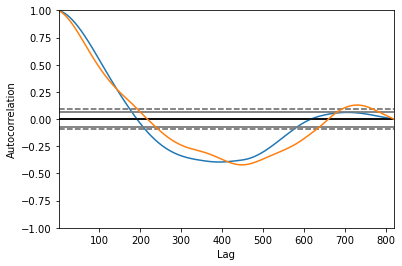

In [6]:
autocorrelation_plot(x[0:9001:11])
autocorrelation_plot(x[1:9001:11])
plt.show()

From the following plots, I can assume that the time series I am dealing with is stationary ie., shows no significant trends or seasonality. Hence, I proceed with the data as it is without any preprocessing steps like detrending or deseasonalising. 

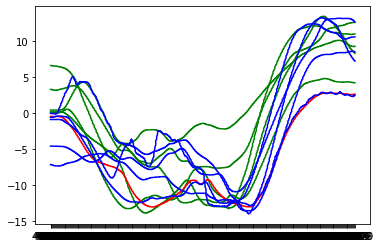

In [7]:
plt.plot(time_steps[0:9000:11], x[0:9001:11], color='green')
plt.plot(time_steps[1:9000:11], x[1:9000:11], color='green')
plt.plot(time_steps[2:9000:11], x[2:9000:11], color='green')
plt.plot(time_steps[3:9000:11], x[3:9000:11], color='green')
plt.plot(time_steps[4:9000:11], x[4:9000:11], color='green')
plt.plot(time_steps[5:9000:11], x[5:9000:11], color='red')
plt.plot(time_steps[6:9000:11], x[6:9001:11], color='blue')
plt.plot(time_steps[7:9000:11], x[7:9000:11], color='blue')
plt.plot(time_steps[8:9000:11], x[8:9000:11], color='blue')
plt.plot(time_steps[9:9000:11], x[9:9000:11], color='blue')
plt.plot(time_steps[10:9000:11], x[10:9000:11], color='blue')

### Implementation

The Jupyter file contains an interactive implementation. If you like, you can run the python script that I have sent, in terminal. Following is a sample command: <br>
python3 training_and_evaluation.py -episodes 50 -num_past_steps 25 -batch_size 64 -begin 0 -end 1000 -load_model 1

I would recommend to load the pre-trained models, one corresponding to number of past time steps 100 and the other one 25. 

In [4]:
import numpy as np
import os
import pandas as pd
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt

from keras.utils import np_utils
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization
from tensorflow.python.keras.callbacks import History


In [7]:
#Normalization
#x = (x-np.mean(x))/np.std(x)
#y = (y-np.mean(y))/np.std(y)
#z = (z-np.mean(z))/np.std(z)

In [9]:
num_time_steps = time_steps.shape[0]
data = np.concatenate((x,y,z))
data = data.reshape(3, num_time_steps)
player=[]
for i in range (11):
    player1 = data[:, i:num_time_steps:11]
    player.append(player1)

In [10]:
data =  np.array(player)

In [11]:
data.shape

(11, 3, 95325)

In [12]:
data=data.reshape(33, 95325)

In [12]:
#in my previous implementation I used reshape instead of transpose and that created a havoc
def create_dataset(num_past_steps, data):
    x = []
    y = []
    for i in range(95224):                           #num_time_steps/11 = 95325  
        #print(i)
        p = np.matrix.transpose(data[:,i:i+num_past_steps])    #training data
        x.append(p)
        q = np.matrix.transpose(data[:,i+num_past_steps])    #test data
        y.append(q)
        
    return np.array(x), np.array(y)

In [51]:
data_X, label = create_dataset(25, data)

In [52]:
train_x, train_label = data_X[0:95000][:][:], label[0:95000][:][:] 

In [53]:
test_x, test_label = data_X[95000:][:][:], label[95000:][:][:] 

In [56]:
test_label.shape

(224, 33)

In [60]:
train_label=train_label.reshape(95000,1,33)
test_label=test_label.reshape(224,1,33)

### Training

In [44]:
def RNN(past_time_steps):
    inputs = Input(name='inputs',shape=(past_time_steps, 33))  
    #layer = BatchNormalization()(inputs)
    layer = LSTM(64, return_sequences=True)(inputs)
    layer = Activation('relu')(layer)
    layer = Dropout(0.2)(layer)   
    #layer = LSTM(32, return_sequences=False)(layer)
    layer = Dense(128,name='FC2')(layer)
    layer = Activation('relu')(layer)
                      
                                                     
    layer = Dense(33,name='out_layer')(layer)       
    model = Model(inputs=inputs,outputs=layer)
    return model

#Compile the model
model_25_ = RNN(25)   #or 100
model_25_.summary(25) #or 100
model_25_.compile(loss='mse',optimizer='adam',metrics=['accuracy']) #or 100

#Fit on training data
#model1.fit(trainx_array_new,label_array_new,batch_size=64,epochs=10, validation_split=0.2, shuffle='True')

Model: "model_5"
_________________________
Layer (typ Output Sh Para
inputs (In [(None, 2 0   
_________________________
lstm_5 (LS (None, 25 2508
_________________________
activation (None, 25 0   
_________________________
dropout_1  (None, 25 0   
_________________________
FC2 (Dense (None, 25 8320
_________________________
activation (None, 25 0   
_________________________
out_layer  (None, 25 4257
Total params: 37,665
Trainable params: 37,665
Non-trainable params: 0
_________________________


In [45]:
model_25_.fit(train_x, train_label,batch_size=64,epochs=100, validation_split=0.2, shuffle='True')

Epoch 1/100
1188/1188 [==============================] - 36s 24ms/step - loss: 9.4564 - accuracy: 0.2410 - val_loss: 3.0982 - val_accuracy: 0.5603
Epoch 2/100
1188/1188 [==============================] - 33s 28ms/step - loss: 3.0189 - accuracy: 0.4494 - val_loss: 2.9364 - val_accuracy: 0.5545
Epoch 3/100
1188/1188 [==============================] - 30s 26ms/step - loss: 2.6847 - accuracy: 0.4675 - val_loss: 2.9820 - val_accuracy: 0.5587
Epoch 4/100
1188/1188 [==============================] - 32s 27ms/step - loss: 2.4826 - accuracy: 0.4777 - val_loss: 2.8698 - val_accuracy: 0.5666
Epoch 5/100
1188/1188 [==============================] - 32s 27ms/step - loss: 2.3076 - accuracy: 0.4877 - val_loss: 2.9338 - val_accuracy: 0.5507
Epoch 6/100
1188/1188 [==============================] - 36s 30ms/step - loss: 2.2094 - accuracy: 0.4958 - val_loss: 2.9588 - val_accuracy: 0.5322
Epoch 7/100
1188/1188 [==============================] - 33s 28ms/step - loss: 2.1440 - accuracy: 0.5002 - val_loss: 3

In [61]:
#Test result:
model_25_.evaluate(test_x, test_label)

7/7 [==============================] - 5s 7ms/step - loss: 3.7754 - accuracy: 0.7379


[3.7754178047180176, 0.7378571629524231]

In [62]:
#Data preparation for model_100_

In [21]:
data_X, label = create_dataset(100, data)
train_x, train_label = data_X[0:95000][:][:], label[0:95000][:][:] 
test_x, test_label = data_X[95000:][:][:], label[95000:][:][:]
train_label=train_label.reshape(95000,1,33)

In [26]:
test_label=test_label.reshape(224,1,33)

In [20]:
test_label=test_label.reshape(224,1,3)

ValueError: cannot reshape array of size 7392 into shape (224,1,3)

In [16]:
import keras
model_100_ = keras.models.load_model("my_model100")

In [48]:
#Compile the model
model_100_ = RNN(100)   
model_100_.summary(100) 
model_100_.compile(loss='mse',optimizer='adam',metrics=['accuracy']) 
model_100_.fit(train_x, train_label,batch_size=64,epochs=100, validation_split=0.2, shuffle='True')

Model: "model_7"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
inputs (InputLayer)                          [(None, 100, 33)]                       0              
____________________________________________________________________________________________________
lstm_7 (LSTM)                                (None, 100, 64)                         25088          
____________________________________________________________________________________________________
activation_10 (Activation)                   (None, 100, 64)                         0              
____________________________________________________________________________________________________
dropout_3 (Dropout)                          (None, 100, 64)                         0              
__________________________________________________________________________

KeyboardInterrupt: 

In [27]:
#Test results: 
model_100_.evaluate(test_x, test_label)

7/7 [==============================] - 9s 23ms/step - loss: 6.7734 - accuracy: 0.1204


[6.773382663726807, 0.12044642865657806]

In [50]:
model_100_.save('my_model100')
model_25_.save('my_model25')

INFO:tensorflow:Assets written to: my_model100\assets


INFO:tensorflow:Assets written to: my_model100\assets


INFO:tensorflow:Assets written to: my_model25\assets


INFO:tensorflow:Assets written to: my_model25\assets


### Variance Test

In [5]:
nba_uta = pd.read_csv('2019040129_nba-uta_TRACKING.csv')

In [6]:
nba_gsw = pd.read_csv('2019051610_nba-gsw_TRACKING.csv')

In [8]:
def data_preprocessing(raw_data):
        
    #team = raw_data['team']
    #data = 0
    
    #for i in range (len(raw_data['ts'])):
        #if team[i]=='team_ball':
            #team[i]='team_2'
        
    #team = np.array(team)
    #team_processed = np.zeros([len(team)])
    #for i in range (len(team)): 
        #team_processed[i] = int(team[i][5])
            
    num_time_steps = time_steps.shape[0]
    data = np.concatenate((raw_data['x'],raw_data['y'],raw_data['z']))
    data = data.reshape(3, num_time_steps)
    player=[]
    for i in range (11):
        player1 = data[:, i:num_time_steps:11]
        player.append(player1)
    
    data =  np.array(player)
    
    return data

In [18]:
data = data_preprocessing(nba_gsw)

In [19]:
data=data.reshape(33,95325)

In [25]:
x, y = create_dataset(25, data)

In [28]:
len(y)

95224

In [26]:
y=y.reshape(95224,1,33)

## NBA_UTA

In [44]:
model_25_.evaluate(x[0:6000], y[0:6000], batch_size=64)

94/94 [==============================] - 6s 8ms/step - loss: 3.1988 - accuracy: 0.5074


[3.198753595352173, 0.5073666572570801]

In [16]:
model_100_.evaluate(x[0:6000], y[0:6000], batch_size=64)

94/94 [==============================] - 17s 26ms/step - loss: 12.2466 - accuracy: 0.2411


[12.246556282043457, 0.24110166728496552]

## NBA_GSW

In [22]:
model_100_.evaluate(x[0:6000], y[0:6000], batch_size=64)

94/94 [==============================] - 3s 27ms/step - loss: 15.7371 - accuracy: 0.2476


[15.73711109161377, 0.24758833646774292]

In [27]:
model_25_.evaluate(x[0:6000], y[0:6000], batch_size=64)

94/94 [==============================] - 2s 8ms/step - loss: 3.1692 - accuracy: 0.4347


[3.1692137718200684, 0.434746652841568]

### Further steps:

1. First of all, training the same model with around 200 to 400 epochs as there is a clear scope of increasing the training accuracy. 
2. Combining all the three time series and evaluating with the same RNN architecture.
3. Architectural tweaks, like batch normalization, adding LSTM layers etc. 
4. Predicting more than 1 future time steps either in a regressive way (feeding network outputs to the model and predicting the next step), or by directly making labels 2-dimensional.
5. Model player interacrions like euclidean distances, playing position etc. (giving rise to a graph), and then apply min-cost flow for time series forecasting.
6. Trying out generative RNNs and Variational Autoencoders, to perform uncertainty quantification and generate scenarios that were never seen before, but have the same posterior distribution p(z|x), z:=latent variables describing space dynamics, x:=states. This can also be used for data augmentation. 
7. In case the underlying dynamics can also be learnt, then particle filter is also a solution. I am not sure how else to model the underlying dynamics.